In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
pd.options.display.max_columns = None
pd.options.display.max_rows = None
matplotlib.rcParams.update({'font.size': 22})
from pytz import timezone as tz
import gluonts
import pickle

In [6]:
import sys
sys.path.append("..")
import src.constants.files as files
import src.constants.columns as c

from src.evaluation.plots import plot_consumptions

In [4]:
region_df_dict = pickle.load(open(files.REGION_DF_DICT, "rb"))

c:\users\vincent_villet\envs\xebicon\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


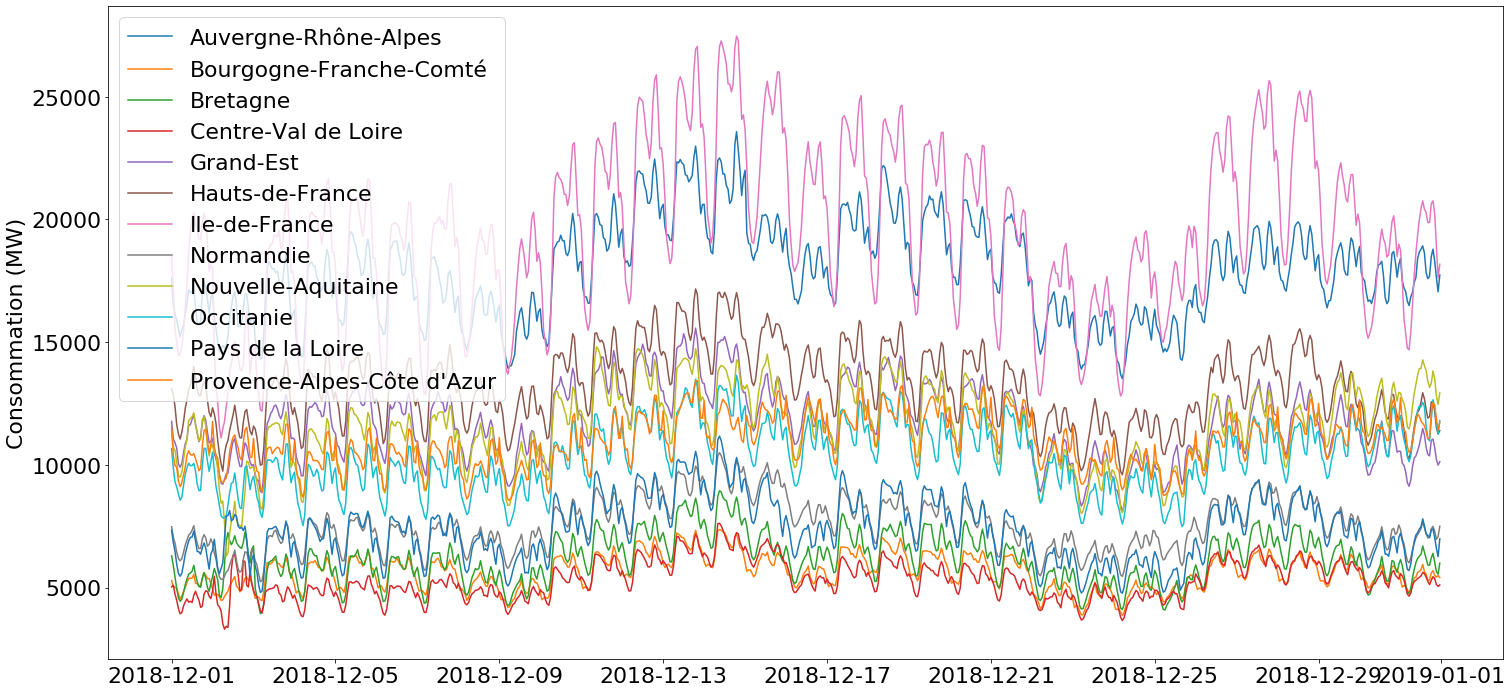

In [7]:
plot_consumptions(region_df_dict, 2018, 12)
plt.show()

# Fonctions pour entraînement DeepAR

In [13]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, regions_list, target_col, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_hours_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate = learning_rate,
                                                learning_rate_decay_factor=0.01, patience=patience),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:end_train_date]
                                   for feat_dynamic_col in feat_dynamic_cols] 
             }
            for region in regions_list],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:end_train_date]
             }
            for region in regions_list],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, regions_list, target_col, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:test_date + timedelta(hours=nb_hours_pred)]
                                   for feat_dynamic_col in feat_dynamic_cols]
             }
            for region in regions_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region][target_col][:test_date + timedelta(hours=nb_hours_pred)],
             }
            for region in regions_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots, figname):
    label_fontsize = 16
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        
        results_mean = forecast.mean
        ground_truth = df_dict[forecast.item_id]["Consommation (MW)"][
            test_date + timedelta(hours=1):test_date + timedelta(hours=nb_hours_pred)].values
        MAPE = np.mean(np.apply_along_axis(abs, 0, (ground_truth - results_mean) / ground_truth))
        plt.title(forecast.item_id + " MAPE:{}%".format(str(round(100*MAPE, 1))))
        plt.ylabel("Consumption (MW)")
        plt.xlabel("")
        ax.set_xlim([test_date - timedelta(days=nb_hours_pred/24), test_date + timedelta(days=nb_hours_pred/24)])
        ax.set_ylim([12000, 28000])
        xticks = [test_date + timedelta(days=x) for x in [-11, -7, -3, 0, 4, 8, 12]]
        ax.set_xticks(xticks, minor=True)
        ax.set_xticklabels([datetime.strftime(date, "%Y-%m-%d") for date in xticks if date != test_date],
                           minor=True, fontsize=label_fontsize)
        ax.set_xticklabels(["", datetime.strftime(test_date, "%Y-%m-%d"), ""], minor=False,
                           fontsize=label_fontsize)
        yticks = np.arange(14000, 28000, step=2000)
        ax.set_yticks(yticks)
        ax.set_yticklabels([str(x) for x in yticks], fontsize=label_fontsize)
        plt.savefig("./figures/{}.png".format(figname))
        plt.show()

INFO:root:Using CPU


# Test Île de France

In [14]:
idf_list = ["Ile-de-France"]

idf_predictor = train_predictor(df_dict, end_train_date, idf_list,
                                target_col="Consommation (MW)", feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:30<00:00,  1.64it/s, avg_epoch_loss=10.4]
INFO:root:Epoch[0] Elapsed time 30.453 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.384240
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:26<00:00,  1.91it/s, avg_epoch_loss=9.47]
INFO:root:Epoch[1] Elapsed time 26.140 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.470777
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:25<00:00,  1.93it/s, avg_epoch_loss=9.05]
INFO:root:Epoch[2] Elapsed time 25.954 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.049326
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:26<00:00,  1.89it/s, avg_epoch_loss=8.64]
INFO:root:Epoch[3] Elapsed time 26.400 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.637879
INFO:root:Epo

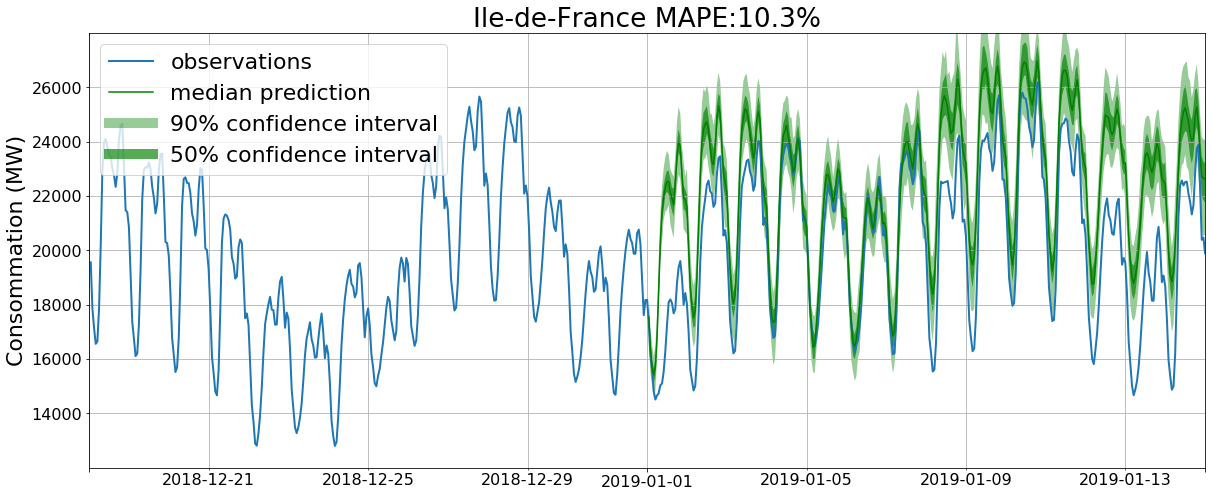

In [15]:
matplotlib.rcParams.update({'font.size': 22})
forecasts, tss = make_predictions(idf_predictor, df_dict, test_date, idf_list, target_col="Consommation (MW)")
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1, figname="Paris seul")

# Test sur toutes les régions

In [16]:
all_regions = pd.unique(df["Région"])

all_reg_predictor = train_predictor(df_dict, end_train_date, all_regions,
                                    target_col="Consommation (MW)", feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:30<00:00,  1.65it/s, avg_epoch_loss=10]  
INFO:root:Epoch[0] Elapsed time 30.225 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.041547
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:25<00:00,  1.94it/s, avg_epoch_loss=8.97]
INFO:root:Epoch[1] Elapsed time 25.824 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.970116
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [00:25<00:00,  1.95it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[2] Elapsed time 25.665 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.363366
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:25<00:00,  1.94it/s, avg_epoch_loss=8.15]
INFO:root:Epoch[3] Elapsed time 25.734 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.148341
INFO:root:Epo

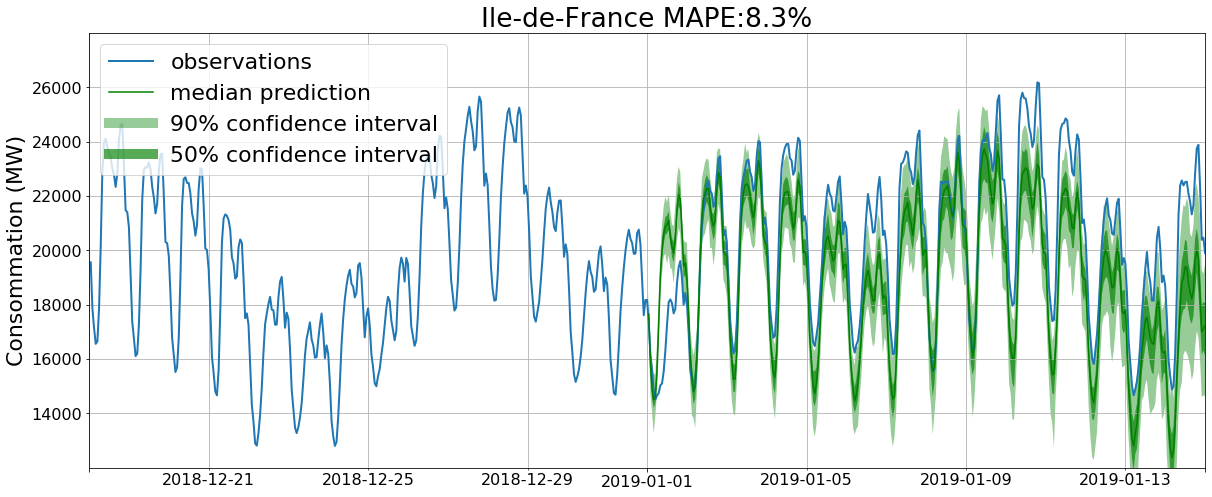

In [17]:
matplotlib.rcParams.update({'font.size': 22})
forecasts, tss = make_predictions(all_reg_predictor, df_dict, test_date, ["Ile-de-France"], target_col="Consommation (MW)")
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1, figname="Paris et autres régions")

# Test Île de France avec température de Paris maximale du jour

In [18]:
idf_list = ["Ile-de-France"]

temp_pred = train_predictor(df_dict, end_train_date, idf_list,
                                    target_col="Consommation (MW)", feat_dynamic_cols=["max_temp_paris"])

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.0001
100%|██████████| 50/50 [00:30<00:00,  1.65it/s, avg_epoch_loss=11]  
INFO:root:Epoch[0] Elapsed time 30.388 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.008494
INFO:root:Epoch[1] Learning rate is 0.0001
100%|██████████| 50/50 [00:26<00:00,  1.91it/s, avg_epoch_loss=9.87]
INFO:root:Epoch[1] Elapsed time 26.208 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.872501
INFO:root:Epoch[2] Learning rate is 0.0001
100%|██████████| 50/50 [21:15<00:00, 25.52s/it, avg_epoch_loss=9.35]   
INFO:root:Epoch[2] Elapsed time 1275.784 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.350626
INFO:root:Epoch[3] Learning rate is 0.0001
100%|██████████| 50/50 [00:26<00:00,  1.91it/s, avg_epoch_loss=9.1] 
INFO:root:Epoch[3] Elapsed time 26.181 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=9.102122
INFO:roo

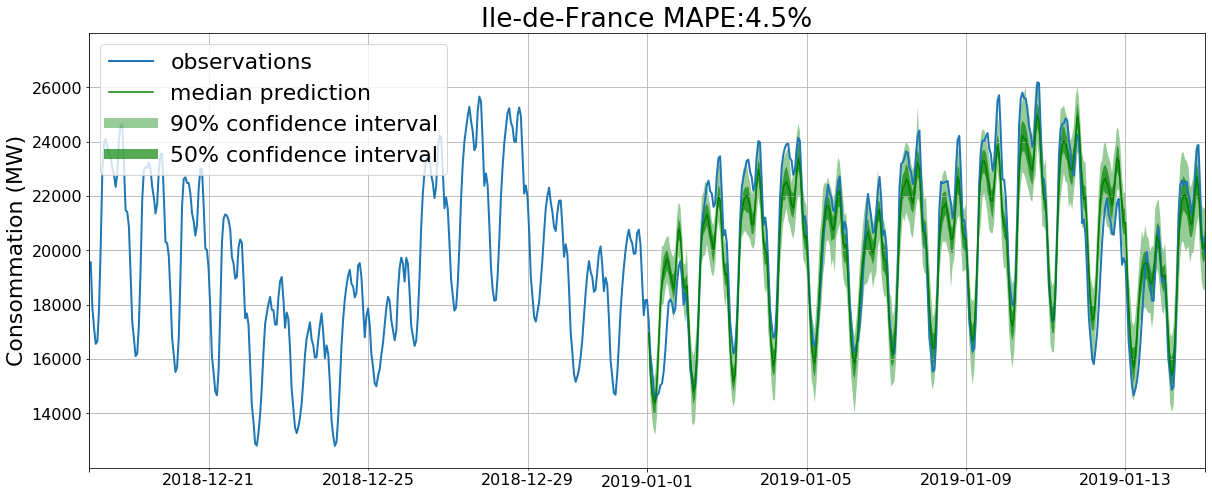

In [19]:
matplotlib.rcParams.update({'font.size': 22})
forecasts, tss = make_predictions(temp_pred, df_dict, test_date, idf_list, target_col="Consommation (MW)",
                                 feat_dynamic_cols=["max_temp_paris"])
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1, figname="Paris et température")